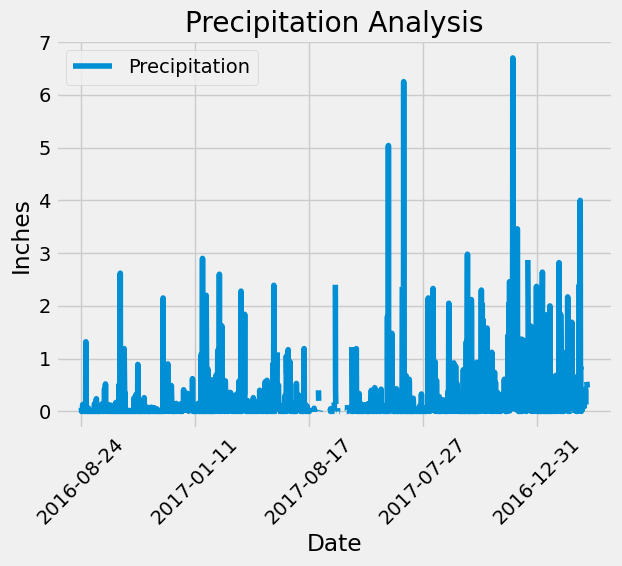

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


InterfaceError: (sqlite3.InterfaceError) Error binding parameter 1 - probably unsupported type.
[SQL: SELECT measurement.date AS measurement_date, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.station = ? AND measurement.date >= ?]
[parameters: ('USC00519281', Timestamp('2016-08-23 00:00:00'))]
(Background on this error at: https://sqlalche.me/e/14/rvf5)

In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import datetime as dt 
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify

# Part 1: Analyze and Explore the Climate Data
# Connect to the SQLite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Reflect tables into classes and save references
Base = automap_base()
Base.prepare(engine, reflect=True)

Station = Base.classes.station
Measurement = Base.classes.measurement

# Create a session to link Python to the database
session = Session(engine)

# Perform a precipitation analysis
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = pd.to_datetime(latest_date) - pd.DateOffset(days=365)
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= str(one_year_ago)).all()
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df.plot(title='Precipitation Analysis', rot=45)
plt.ylabel('Inches')
plt.show()
print(precipitation_df.describe())

# Perform a station analysis
total_stations = session.query(func.count(Station.station)).scalar()
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
tobs_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= one_year_ago).all()
tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'Temperature'])
tobs_df.plot.hist(title='Temperature Observation (TOBS) Analysis', bins=12)
plt.xlabel('Temperature (°F)')
plt.show()

# Part 2: Design Climate App
app = Flask(__name__)

@app.route('/')
def homepage():
    return "Welcome to the Climate App! Use the available routes for data."

@app.route('/api/v1.0/precipitation')
def precipitation():
    # Query precipitation data for the last year
    last_year_precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

    # Convert the query results to a dictionary with date as the key and precipitation as the value
    precipitation_dict = {date: prcp for date, prcp in last_year_precipitation}

    return jsonify(precipitation_dict)

@app.route('/api/v1.0/stations')
def stations():
    # Query all stations
    all_stations = session.query(Station.station, Station.name).all()

    # Convert the query results to a list of dictionaries
    stations_list = [{"station": station, "name": name} for station, name in all_stations]

    return jsonify(stations_list)

@app.route('/api/v1.0/tobs')
def tobs():
    # Query TOBS data for the most active station and the last year
    tobs_data = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == most_active_station).\
        filter(Measurement.date.between(str(one_year_ago), str(latest_date))).all()





    # Convert the query results to a list of dictionaries
    tobs_list = [{"date": date, "temperature": tobs} for date, tobs in tobs_data]

    return jsonify(tobs_list)

@app.route('/api/v1.0/<start>')
def temperature_stats_start(start):
    # Query temperature statistics from the start date to the end of the dataset
    temperature_stats_start = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start).all()

    # Convert the query results to a dictionary
    temperature_stats_dict_start = {
        "min_temperature": temperature_stats_start[0][0],
        "max_temperature": temperature_stats_start[0][1],
        "avg_temperature": temperature_stats_start[0][2]
    }

    return jsonify(temperature_stats_dict_start)

@app.route('/api/v1.0/<start>/<end>')
def temperature_stats_start_end(start, end):
    # Query temperature statistics from the start date to the end date
    temperature_stats_start_end = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start).filter(Measurement.date <= end).all()

    # Convert the query results to a dictionary
    temperature_stats_dict_start_end = {
        "min_temperature": temperature_stats_start_end[0][0],
        "max_temperature": temperature_stats_start_end[0][1],
        "avg_temperature": temperature_stats_start_end[0][2]
    }

    return jsonify(temperature_stats_dict_start_end)

if __name__ == '__main__':
    app.run(debug=True)

# Close the session
session.close()
